In [1]:
import os
import shutil
import h5py
import random
import glob
import argparse
import numpy as np
from astropy.nddata.utils import Cutout2D
from shutil import copyfile
from astropy.io import fits
import pandas as pd
from astropy.wcs import WCS, utils
from astropy.coordinates import SkyCoord
import astropy.units as units
from astropy.wcs.utils import skycoord_to_pixel
import warnings
import time

In [2]:
def make_cutout(img, x, y):
    ''' Creates the image cutout given a tile, the position of the center and the band '''

    img_cutout = Cutout2D(img.data, (x, y), cutout_size, mode="partial", fill_value=0).data

    if np.count_nonzero(np.isnan(img_cutout)) >= 0.05 * cutout_size ** 2 or np.count_nonzero(
            img_cutout) == 0:  # Don't use this cutout
        return np.zeros((cutout_size, cutout_size))

    img_cutout[np.isnan(img_cutout)] = 0

    return img_cutout


def ra_dec_to_xy(fits, ra, dec, band):
    if band in ['i', 'z']:
        head = fits[1].read_header()
    else:
        head = fits[0].read_header()
    w = WCS(head)
    return skycoord_to_pixel(SkyCoord(ra, dec, unit="deg"), w)

def show_scale(fits_file):
    hdulist = fits.open(fits_file) #open fits file
    if (file.split('.')[-2] in ['z'] or file.split('/')[-1].startswith('calexp')):
        exp = 1
    else:
        exp = 0
    header = hdulist[exp].header #get header of first extension
    wcs = WCS(header)
    ra = header['CRVAL1']
    dec = header['CRVAL2']
    pix_scale = abs(header['CD1_1']*3600)
    dim_x_deg = header['NAXIS1']*pix_scale/3600
    dim_y_deg = header['NAXIS2']*pix_scale/3600
    return ra, dec, pix_scale, dim_x_deg, dim_y_deg

In [3]:
file_path = '/home/nick/astro/UNIONS/lsb-detection-pipeline/NGC5457_test/fields/CFIS_LSB.246.289.r/'
fits_file_g = 'calexp-CFIS_246_289.fits'
fits_file_u = 'CFIS.246.289.u.fits'
fits_file_r = 'CFIS_LSB.246.289.r.fits'
fits_file_z = 'WISHES.246.289.z.fits'
fits_file_i = 'PS-DR3.246.289.i.fits'

In [4]:
file = os.path.join(file_path,fits_file_u)
show_scale(file)

(211.81225064, 54.5, 0.185768447408928, 0.5160234650248, 0.5160234650248)

In [5]:
file = os.path.join(file_path,fits_file_g)
show_scale(file)

(211.812250635808,
 54.5,
 0.1857684474089298,
 0.516023465024805,
 0.516023465024805)

In [8]:
file = os.path.join(file_path,fits_file_r)
show_scale(file)

(211.81225064, 54.5, 0.185768447408928, 0.5160234650248, 0.5160234650248)

In [9]:
file = os.path.join(file_path,fits_file_i)
show_scale(file)

(211.81225064, 54.5, 0.185768447408928, 0.5160234650248, 0.5160234650248)

In [10]:
file = os.path.join(file_path,fits_file_z)
show_scale(file)

(211.812250635808,
 54.5,
 0.18576844740891937,
 0.516023465024776,
 0.516023465024776)

## Relate ra, dec to tile numbers

In [11]:
def relate_coord_tile(coords=None, nums=None):
    """
    Conversion between tile numbers and coordinates.
    :param coords: right ascention, declination; tuple
    :param nums: first and second tile numbers; tuple
    :return: depending on the input, return the tile numbers or the ra and dec coordinates
    """
    if coords:
        ra, dec = coords
        xxx=ra*2*np.cos(np.radians(dec))
        yyy=(dec+90)*2
        return int(xxx), int(yyy)
    else:
        xxx, yyy = nums
        dec=yyy/2-90
        ra=xxx/2/np.cos(np.radians(dec))
        return np.round(ra,12), np.round(dec,12)

## Get lists of currently available tiles for each band

In [39]:
def update_available_tiles(path, save=True):
    """
    Update available tile lists from the VOSpace. Takes a few mins to run.
    :param path: path to save tile lists.
    :param save: save new lists to disk, default is True.
    :return: /
    """
    cfis_u_tiles = client.glob1('vos:cfis/tiles_DR5/','*u.fits')
    whigs_g_tiles = client.glob1('vos:cfis/whigs/stack_images_CFIS_scheme/','*.fits')
    cfis_lsb_r_tiles = client.glob1('vos:cfis/tiles_LSB_DR5/','*.fits')
    ps_i_tiles = client.glob1('vos:cfis/panstarrs/DR3/tiles/','*i.fits')
    wishes_z_tiles = client.glob1('vos:cfis/wishes_1/coadd/','*.fits')
    if save:
        np.savetxt(path+'cfis_u_tiles.txt', cfis_u_tiles, fmt='%s')
        np.savetxt(path+'whigs_g_tiles.txt', whigs_g_tiles, fmt='%s')
        np.savetxt(path+'cfis_lsb_r_tiles.txt', cfis_lsb_r_tiles, fmt='%s')
        np.savetxt(path+'ps_i_tiles.txt', ps_i_tiles, fmt='%s')
        np.savetxt(path+'wishes_z_tiles.txt', wishes_z_tiles, fmt='%s')
        
def load_available_tiles(path):
    """
    Load tile lists from disk.
    :param path: path to files
    :return: lists of available tiles for the five bands
    """
    u_tiles = np.loadtxt(path+'cfis_u_tiles.txt', dtype=str)
    g_tiles = np.loadtxt(path+'whigs_g_tiles.txt', dtype=str)
    lsb_r_tiles = np.loadtxt(path+'cfis_lsb_r_tiles.txt', dtype=str)
    i_tiles = np.loadtxt(path+'ps_i_tiles.txt', dtype=str)
    z_tiles = np.loadtxt(path+'wishes_z_tiles.txt', dtype=str)
    
    return u_tiles, g_tiles, lsb_r_tiles, i_tiles, z_tiles

def get_tile_numbers(name):
    """
    Extract tile numbers from tile name
    :param name: .fits file name of a given tile
    :return two three digit tile numbers
    """
    parts = name.split('.')
    if name.startswith('calexp'):
        parts = parts[0].split('_')
    xxx, yyy = map(int, parts[1:3])
    return xxx, yyy

def extract_tile_numbers(tile_lists):
    """
    Extract tile numbers from .fits file names.
    :param tile_lists: lists of file names from the different bands
    :return: lists of tile numbers available in the different bands
    """
    u_nums = np.array([get_tile_numbers(name) for name in tile_lists[0]])
    g_nums = np.array([get_tile_numbers(name) for name in tile_lists[1]])
    lsb_r_nums = np.array([get_tile_numbers(name) for name in tile_lists[2]])
    i_nums = np.array([get_tile_numbers(name) for name in tile_lists[3]])
    z_nums = np.array([get_tile_numbers(name) for name in tile_lists[4]])
    
    return u_nums, g_nums, lsb_r_nums, i_nums, z_nums

class TileAvailability:
    def __init__(self, tile_nums, band_dict, at_least=False):
        self.all_tiles = tile_nums
        self.tile_num_sets = [set(map(tuple, tile_array)) for tile_array in self.all_tiles]
        self.unique_tiles = sorted(set.union(*self.tile_num_sets))
        self.availability_matrix = self._create_availability_matrix()
        self.counts = self._calculate_counts(at_least)
        self.band_dict = band_dict

    def _create_availability_matrix(self):
        array_shape = (len(self.unique_tiles), len(self.all_tiles))
        availability_matrix = np.zeros(array_shape, dtype=int)

        for i, tile in enumerate(self.unique_tiles):
            for j, tile_num_set in enumerate(self.tile_num_sets):
                availability_matrix[i, j] = int(tile in tile_num_set)

        return availability_matrix

    def _calculate_counts(self, at_least):
        counts = np.sum(self.availability_matrix, axis=1)
        bands_available, tile_counts = np.unique(counts, return_counts=True)

        counts_dict = dict(zip(bands_available, tile_counts))
        
        if at_least:
            at_least_counts = np.zeros_like(bands_available)
            for i, count in enumerate(bands_available):
                at_least_counts[i] = np.sum(tile_counts[i:])
            counts_dict = dict(zip(bands_available, at_least_counts))
        
        return counts_dict

    def get_availability(self, tile_number):
        try:
            index = self.unique_tiles.index(tuple(tile_number))
        except:
            print('\nTile number not available in any band.')
            return []
        bands_available = np.where(self.availability_matrix[index] == 1)[0]
        return [self.band_dict[list(self.band_dict.keys())[i]]['band'] for i in bands_available], bands_available

    def stats(self):
        print("\nNumber of currently available tiles per band:\n")
        max_band_name_length = max(map(len, self.band_dict.keys()))  # for output format
        for band_name, count in zip(self.band_dict.keys(), np.sum(self.availability_matrix, axis=0)):
            print(f"{band_name.ljust(max_band_name_length)}: \t {count}")
        
        print("\nNumber of tiles available in different bands:\n")
        for bands_available, count in sorted(self.counts.items(), reverse=True):
            print(f"In {bands_available} bands: {count}")
            
        print('\nNumber of unique tiles available:\n\n' \
             f'{len(self.unique_tiles)}')

In [40]:
from vos import Client
client = Client()

band_dict = {'cfis-u': {'name': 'CFIS', 'band': 'u', 'vos': 'vos:cfis/tiles_DR5/', 'suffix': '.u.fits', 'delimiter': '.', 'fits_ext': 0},
            'whigs-g': {'name': 'calexp-CFIS', 'band': 'g', 'vos': 'vos:cfis/whigs/stack_images_CFIS_scheme/', 'suffix': '.fits', 'delimiter': '_', 'fits_ext': 1},
            'cfis_lsb-r': {'name': 'CFIS_LSB', 'band': 'r', 'vos': 'vos:cfis/tiles_LSB_DR5/', 'suffix': '.r.fits', 'delimiter': '.', 'fits_ext': 0},
            'ps-i': {'name': 'PS-DR3', 'band': 'i', 'vos': 'vos:cfis/panstarrs/DR3/tiles/', 'suffix': '.i.fits', 'delimiter': '.', 'fits_ext': 0},
            'wishes-z': {'name': 'WISHES', 'band': 'z', 'vos': 'vos:cfis/wishes_1/coadd/', 'suffix': '.z.fits', 'delimiter': '.', 'fits_ext': 1}}

parent_dir = '/home/nick/astro/TileSlicer/'
tile_dir = os.path.join(parent_dir, 'tile_info/')
os.makedirs(tile_dir, exist_ok=True)
# retrieve from the VOSpace and update the currently available tiles
# takes some time to run
update = False
# return the number of available tiles that are available in at least 5, 4, 3, 2, 1 bands
at_least = False

if update:
    update_available_tiles(tile_dir)
    
u, g, lsb_r, i, z = extract_tile_numbers(load_available_tiles(tile_dir))
all_bands = [u, g, lsb_r, i, z]
availability = TileAvailability(all_bands, band_dict, at_least)
availability.stats()

# Check the availability for a specific tile
tile_number = (243, 290)
tile_coords = relate_coord_tile(nums=tile_number)
avail_bands = availability.get_availability(tile_number)
print(f'\n{avail_bands}')


Number of currently available tiles per band:

cfis-u    : 	 34017
whigs-g   : 	 19528
cfis_lsb-r: 	 20802
ps-i      : 	 22168
wishes-z  : 	 8444

Number of tiles available in different bands:

In 5 bands: 5229
In 4 bands: 9984
In 3 bands: 5007
In 2 bands: 3418
In 1 bands: 17021

Number of unique tiles available:

40659

(['u', 'g', 'r', 'i', 'z'], array([0, 1, 2, 3, 4]))


## Create KD-Tree from tile list

In [16]:
from scipy.spatial import cKDTree
import joblib

def tile_coordinates(name):
    """
    Extract RA and Dec from tile name
    :param name: .fits file name of a given tile
    :return RA and Dec of the tile center
    """
    parts = name.split('.')
    if name.startswith('calexp'):
        parts = parts[0].split('_')
    xxx, yyy = map(int, parts[1:3])
    ra = np.round(xxx / 2 / np.cos(np.radians((yyy / 2) - 90)),6)
    dec = np.round((yyy / 2) - 90,6)
    return ra, dec
    
def build_tree(tiles, path, save=True):
    """
    Build a kd tree from the input tiles to efficiently query object positions.
    :param tiles: list of unique tile number pairs
    :param save: save the built tree to file
    :return: /
    """
    tile_coords = np.array([relate_coord_tile(nums=num) for num in tiles])
    tile_coords_c = SkyCoord(tile_coords[:,0], tile_coords[:,1], unit='deg', frame='icrs')
    tile_coords_xyz = np.array([x.cartesian.xyz.value for x in tile_coords_c])
    tree = cKDTree(tile_coords_xyz)
    if save:
        joblib.dump(tree, path+'kdtree_xyz.joblib')

def query_tree(tiles, coords, path, build=False, save=True):
    """
    Query the kd tree to find what tile an object is in.
    :param tiles: list of tile numbers as tuples
    :param coords: ra, dec of object to query
    :build: if true build the tree first, default=False
    :return tile name and distance object - nearest tile center
    """
    if build:
        build_tree(tiles, path, save)
    loaded_tree = joblib.load(path+'kdtree_xyz.joblib')
    try:
        tile_name, dist = find_tile(loaded_tree, tiles, coords)
        return tile_name, dist
    except ValueError as e:
        return np.nan, f'Error: {e}'

class TileWCS:
    def __init__(self, wcs_keywords={}):
        wcs_keywords.update({
                'NAXIS': 2,
                'CTYPE1': 'RA---TAN',
                'CTYPE2': 'DEC--TAN',
                'CRVAL1': 0,
                'CRVAL2': 0,
                'CRPIX1': 5000.0,
                'CRPIX2': 5000.0,
                'CD1_1': -5.160234650248e-05,
                'CD1_2': 0.0,
                'CD2_1': 0.0,
                'CD2_2': 5.160234650248e-05,
                'NAXIS1': 10000,
                'NAXIS2': 10000
        })
            
        self.wcs = WCS(wcs_keywords)

    def set_coords(self, coords):
        self.wcs.wcs.crval = [coords[0], coords[1]]
        
def find_tile(tree, tiles, object_coord):
    """
    Query the tree and find the tile the object is in.
    :param tree: kd tree
    :param tiles: list of unique tiles in the survey
    :param object_coord: coordinates of the object we want to find a tile for
    :return: tile numbers of the matching tile
    """
    coord_c = SkyCoord(object_coord[0], object_coord[1], unit='deg', frame='icrs')
    coord_xyz = coord_c.cartesian.xyz.value
    dists, indices = tree.query(coord_xyz, k=4)
    wcs = TileWCS()
    for dist, idx in zip(dists,indices):
        wcs.set_coords(relate_coord_tile(nums=tiles[idx]))
        if wcs.wcs.footprint_contains(coord_c):
            return tiles[idx], dist
    raise ValueError('Object could not be assigned to a tile.')

In [269]:
tiles = availability.unique_tiles
obj_coord = 134.5670522, 85.2508887
obj_coord_c = SkyCoord(obj_coord[0], obj_coord[1], unit='deg', frame='icrs')
tile_numbers, dist_nn = query_tree(tiles, obj_coord, path, build=False)
if dist_nn:
    center_coord = relate_coord_tile(nums=tile_numbers)
    center_coord_c = SkyCoord(center_coord[0], center_coord[1], unit='deg', frame='icrs')
    sep_skycoord = obj_coord_c.separation(center_coord_c).deg
    sep_tree = np.degrees(dist_nn)
    print(f'The object is in tile number {tile_numbers}.')
    print(f'The distance to the nearest tile center is {np.round(np.degrees(dist_nn),3)} degrees.')
# print(f'Distance skycoord: {sep_skycoord}, distance tree: {sep_tree}')

The object is in tile number (24, 350).
The distance to the nearest tile center is 0.365 degrees.


## Download a specific tile

### Test client speed

In [17]:
start_time = time.time()
file_name = 'CFIS_LSB.143.900.r.fits'
client.copy(f'vos:cfis/tiles_LSB_DR5/{file_name}', f'/home/nick/astro/ssl-spencer/{file_name}')
print(f'Finished download. Took {(time.time()-start_time)/60} minutes')

NameError: name 'time' is not defined

### Test command line speed

In [113]:
start_time = time.time()
file_name = 'CFIS_LSB.143.321.r.fits'
vos_copy_command = f'vcp -v vos:cfis/tiles_LSB_DR5/{file_name}'
os.system(vos_copy_command + f' /home/nick/astro/ssl-spencer/temp_dir/{file_name}')
print(f'Finished download. Took {(time.time()-start_time)/60} minutes')

INFO vcp vos:cfis/tiles_LSB_DR5/CFIS_LSB.143.321.r.fits -> /home/nick/astro/ssl-spencer/temp_dir/CFIS_LSB.143.321.r.fits 


Finished download. Took 12.658307552337646 minutes


# Pipeline outline

In [19]:
cat_dir = '/home/nick/astro/UNIONS/lsb-detection-pipeline/NGC5457_test/'
catalog = pd.read_csv(cat_dir+'NGC5485_dwarfs.csv')
ra_key, dec_key = 'ra', 'dec'
coord_c = SkyCoord(catalog[ra_key].values, catalog[dec_key].values, unit='deg', frame='icrs')

In [32]:
catalog_dir = os.path.join(parent_dir, 'tables/')
os.makedirs(catalog_dir, exist_ok = True)
catalog = pd.read_csv(catalog_dir+'df_coordinates.csv')
ra_key, dec_key = 'ra', 'dec'
coord_c = SkyCoord(catalog[ra_key].values, catalog[dec_key].values, unit='deg', frame='icrs')

### Get a list of tiles the objects are in

In [41]:
import time
start_time = time.time()
# list tiles the objects are in
# update_available_tiles(path)
u, g, lsb_r, i, z = extract_tile_numbers(load_available_tiles(tile_dir))
all_bands = [u, g, lsb_r, i, z]
availability = TileAvailability(all_bands, band_dict)
tiles = availability.unique_tiles

def tile_finder(availability, catalog, band_constraint=5):
    available_tiles = availability.unique_tiles
    all_tiles = np.empty(len(catalog), dtype=tuple)
    pix_coords = np.empty((len(catalog),2), dtype=np.float64)
    for i , obj_coord in enumerate(coord_c):
        tile_numbers, _ = query_tree(available_tiles, np.array([obj_coord.ra.deg, obj_coord.dec.deg]), tile_dir, build=False)
        all_tiles[i] = tile_numbers
        wcs = TileWCS()
        wcs.set_coords(relate_coord_tile(nums=tile_numbers))
        pix_coord = skycoord_to_pixel(obj_coord, wcs.wcs, origin=1)
        pix_coords[i] = pix_coord

    # add tile numbers and pixel coordinates to catalog
    catalog['tile'] = all_tiles
    catalog['x'] = pix_coords[:,0]
    catalog['y'] = pix_coords[:,1]
    unique_tiles = list(set(all_tiles))
    tiles_x_bands = [tile for tile in unique_tiles if len(availability.get_availability(tile)) == band_constraint]
    
    return unique_tiles, tiles_x_bands

unique_tiles, tiles_x_bands = tile_finder(availability, catalog, band_constraint=5)

print(f'Time: {np.round(time.time()-start_time,3)}')

Time: 0.218


### Only keep tiles that are available in five bands

In [87]:
tiles_x_bands = [tile for tile in unique_tiles if len(availability.get_availability(tile)[1]) == 3]

In [88]:
tiles_x_bands

[(229, 241), (228, 242)]

In [97]:
avail_idx = availability.get_availability(tiles_x_bands[0])[1]
np.asarray(list(band_dict.keys()))[avail_idx]

array(['cfis-u', 'whigs-g', 'cfis_lsb-r'], dtype='<U10')

### Download the selected tiles

In [80]:
def download_tile_for_bands(availability, tile_numbers, band_dict, download_dir, method='api'):
    avail_idx = availability.get_availability(tile_numbers)[1]
    for band in np.array(list(band_dict.keys()))[avail_idx]:
        vos_dir = band_dict[band]['vos']
        prefix = band_dict[band]['name']
        suffix = band_dict[band]['suffix']
        delimiter = band_dict[band]['delimiter']
        tile_dir = download_dir+f'{tile_numbers[0]}_{tile_numbers[1]}'
        os.makedirs(tile_dir, exist_ok=True)
        tile_fitsfilename = f'{prefix}{delimiter}{tile_numbers[0]}{delimiter}{tile_numbers[1]}{suffix}'
        # use a temporary name while the file is downloading
        temp_name = '.'.join(tile_fitsfilename.split('.')[:-1])+'_temp.fits'
        
        # Check if the directory exists, and create it if not
        if os.path.exists(os.path.join(tile_dir, tile_fitsfilename)):
            print(f'File {tile_fitsfilename} was already downloaded.')
        else:
            print(f'Downloading {tile_fitsfilename}..')
            try:
                if method == 'command':
                    # command line
                    os.system(f'vcp -v {vos_dir+tile_fitsfilename} {os.path.join(tile_dir,temp_name)}')
                else:
                    # api
                    client.copy(os.path.join(vos_dir, tile_fitsfilename), os.path.join(tile_dir, temp_name))
                os.rename(os.path.join(tile_dir,temp_name), os.path.join(tile_dir,tile_fitsfilename))
            except Exception as e:
                print(e)
                return False
    return True

In [82]:
import time
from vos import Client
client = Client()

start = time.time()

download_dir = os.path.join(parent_dir, 'data/')
os.makedirs(download_dir, exist_ok=True)
for tile in tiles_x_bands:
    if download_tile_for_bands(availability, tile, band_dict, download_dir, method='command'):
        print(f'Files downloaded. Took {(time.time()-start)/60} minutes.')

File CFIS.229.241.u.fits was already downloaded.
File calexp-CFIS_229_241.fits was already downloaded.
File CFIS_LSB.229.241.r.fits was already downloaded.
Files downloaded. Took 1.4940897623697916e-05 minutes.
File CFIS.228.242.u.fits was already downloaded.
File calexp-CFIS_228_242.fits was already downloaded.
File CFIS_LSB.228.242.r.fits was already downloaded.
Files downloaded. Took 2.4863084157307942e-05 minutes.


### Make cutouts & save to HDF5 file

In [90]:
# from line_profiler import LineProfiler
import concurrent.futures
from concurrent.futures import ProcessPoolExecutor
# lp = LineProfiler()


def make_cutout(data, x, y, cutout_size):
    """
    Creates an image cutout centered on the object.
    :param data: image data, 2d array
    :param x: x coordinate of the cutout center
    :param y: y coordinate of the cutout center
    :param cutout_size: cutout size in pixels
    :return: cutout, 2d array
    """
    img_cutout = Cutout2D(data, (x, y), cutout_size, mode="partial", fill_value=0).data

    if np.count_nonzero(np.isnan(img_cutout)) >= 0.05 * cutout_size ** 2 or np.count_nonzero(img_cutout) == 0:  # Don't use this cutout
        return np.zeros((cutout_size, cutout_size))

    img_cutout[np.isnan(img_cutout)] = 0

    return img_cutout


def make_cutouts_all_bands(availability, tile, obj_in_tile, download_dir, in_dict, size):
    """
    Loops over all five bands for a given tile, creates cutouts of the targets and adds them to the band dictionary.
    :param availability: object to retrieve available tiles
    :param tile: tile numbers
    :param obj_in_tile: dataframe containing the known objects in this tile
    :param download_dir: directory storing the tiles
    :param in_dict: band dictionary
    :param size: square cutout size in pixels
    :return: updated band dictionary containing cutout data
    """
    avail_idx = availability.get_availability(tile)[1]
    cutout = np.zeros((len(obj_in_tile), len(in_dict), size, size))
    tile_dir = download_dir+f'{tile[0]}_{tile[1]}'
    for j, band in enumerate(list(in_dict.keys())[avail_idx]):
        prefix = in_dict[band]['name']
        suffix = in_dict[band]['suffix']
        delimiter = in_dict[band]['delimiter']
        fits_ext = in_dict[band]['fits_ext']
        tile_fitsfilename = f'{prefix}{delimiter}{tile[0]}{delimiter}{tile[1]}{suffix}'
        with fits.open(os.path.join(tile_dir, tile_fitsfilename), memmap=True) as hdul:
            data = hdul[fits_ext].data
        for i, (x, y) in enumerate(zip(obj_in_tile.x.values, obj_in_tile.y.values)):
            cutout[i, j] = make_cutout(data, x, y, size)
    return cutout

def save_to_h5(stacked_cutout, tile_numbers, ids, ras, decs, save_path):
    """
    Save cutout data including meta data to file.
    :param stacked_cutout: stacked numpy array of the image data in different bands
    :param tile_numbers: tile numbers
    :param ids: object IDs
    :param ras: right ascention coordinate array
    :param decs: declination coordinate array
    :param save_path: save path
    :return: pass
    """
    print('Saving file: {}'.format(save_path))
    dt = h5py.special_dtype(vlen=str)
    with h5py.File(save_path, 'w', libver='latest') as hf:
        hf.create_dataset('images', data=stacked_cutout.astype(np.float32))
        hf.create_dataset('tile', data=np.asarray(tile_numbers), dtype=np.int32)
        hf.create_dataset('cfis_id', data=np.asarray(ids), dtype=dt)
        hf.create_dataset('ra', data=ras.astype(np.float32))
        hf.create_dataset('dec', data=decs.astype(np.float32))
    pass

def process_tile(tile):
    save_path = os.path.join(cutout_dir, h5_filename + f'_{tile[0]}_{tile[1]}.h5')
    obj_in_tile = catalog.loc[catalog['tile'] == tile]
    cutout = make_cutouts_all_bands(availability, tile, obj_in_tile, download_dir, band_dict, cutout_size)
    save_to_h5(cutout, tile, obj_in_tile.ID.values, obj_in_tile.ra.values, obj_in_tile.dec.values, save_path)
    return cutout


band_dict = {'cfis-u': {'name': 'CFIS', 'band': 'u', 'vos': 'vos:cfis/tiles_DR5/', 'suffix': '.u.fits', 'delimiter': '.', 'fits_ext': 0},
            'whigs-g': {'name': 'calexp-CFIS', 'band': 'g', 'vos': 'vos:cfis/whigs/stack_images_CFIS_scheme/', 'suffix': '.fits', 'delimiter': '_', 'fits_ext': 1},
            'cfis_lsb-r': {'name': 'CFIS_LSB', 'band': 'r', 'vos': 'vos:cfis/tiles_LSB_DR5/', 'suffix': '.r.fits', 'delimiter': '.', 'fits_ext': 0},
            'ps-i': {'name': 'PS-DR3', 'band': 'i', 'vos': 'vos:cfis/panstarrs/DR3/tiles/', 'suffix': '.i.fits', 'delimiter': '.', 'fits_ext': 0},
            'wishes-z': {'name': 'WISHES', 'band': 'z', 'vos': 'vos:cfis/wishes_1/coadd/', 'suffix': '.z.fits', 'delimiter': '.', 'fits_ext': 1}}

parent_dir = '/home/nick/astro/ssl-spencer/'
cutout_dir = os.path.join(parent_dir, 'h5_files/')
os.makedirs(cutout_dir, exist_ok=True)
download_dir = os.path.join(parent_dir, 'data/')
os.makedirs(download_dir, exist_ok=True)
cutout_size = 200
h5_filename = 'cutout_stacks_ugriz_lsb_200x200'
# for line profiling
# lp.add_function(make_cutouts_all_bands)
# lp.add_function(save_to_h5)

# def main():
#     # log tile processing
#     successful_tiles_count = 0
#     total_cutouts_count = 0
#     failed_tiles = []
    
#     for tile in tiles_five_bands:
#         try:
#             save_path = os.path.join(cutout_dir, h5_filename + f'_{tile[0]}_{tile[1]}.h5')
#             obj_in_tile = catalog.loc[catalog['tile'] == tile]
#             cutout = make_cutouts_all_bands(tile, obj_in_tile, download_dir, band_dict, cutout_size)
#             save_to_h5(cutout, tile, obj_in_tile.ID.values, obj_in_tile.ra.values, obj_in_tile.dec.values, save_path)

#             total_cutouts_count += cutout.shape[0]
#             successful_tiles_count += 1
#         except Exception as e:
#             print(f"Failed to process tile {tile}: {str(e)}")
#             failed_tiles.append(tile)
#     print(f'Cutouts created. Took {(time.time()-start)} seconds.')
    
#     print(f'Report:\nTiles processed: {len(tiles_five_bands)}\nCutouts created: {total_cutouts_count}\nFailed_tiles: {len(failed_tiles)}/{len(tiles_five_bands)}')
#     if len(failed_tiles) != 0:
#         print(f'Processing error in tiles: {failed_tiles}.')

def main():
    # log tile processing
    successful_tiles_count = 0
    total_cutouts_count = 0
    failed_tiles = []

    with ProcessPoolExecutor(max_workers=9) as executor:
        future_to_tile = {executor.submit(process_tile, tile): tile for tile in tiles_x_bands}

        for future in concurrent.futures.as_completed(future_to_tile):
            tile = future_to_tile[future]
            try:
                cutout = future.result()
                if cutout is not None:
                    total_cutouts_count += cutout.shape[0]
                    successful_tiles_count += 1
            except Exception as e:
                print(f"Failed to process tile {tile}: {str(e)}")
                failed_tiles.append(tile)

    print(f'Report:\nTiles processed: {len(tiles_x_bands)}\nCutouts created: {total_cutouts_count}\nFailed_tiles: {len(failed_tiles)}/{len(tiles_x_bands)}')
    if len(failed_tiles) != 0:
        print(f'Processing error in tiles: {failed_tiles}.')
            
# wrapper = lp(main)
# wrapper()
start = time.time()
main()
print(f'Tiles processed, took {np.round(time.time()-start,3)} seconds.')

Failed to process tile (229, 241): only integer scalar arrays can be converted to a scalar index
Failed to process tile (228, 242): only integer scalar arrays can be converted to a scalar index
Report:
Tiles processed: 2
Cutouts created: 0
Failed_tiles: 2/2
Processing error in tiles: [(229, 241), (228, 242)].
Tiles processed, took 0.059 seconds.


In [137]:
lp.print_stats()

Timer unit: 1e-09 s

Total time: 0 s
File: /tmp/ipykernel_68958/3417108590.py
Function: make_cutouts_all_bands at line 26

Line #      Hits         Time  Per Hit   % Time  Line Contents
    26                                           def make_cutouts_all_bands(tile, obj_in_tile, download_dir, in_dict, cutout_size):
    27                                               """
    28                                               Loops over all five bands for a given tile, creates cutouts of the targets and adds them to the band dictionary.
    29                                               :param tile: tile numbers
    30                                               :param obj_in_tile: dataframe containing the known objects in this tile
    31                                               :param download_dir: directory storing the tiles
    32                                               :param in_dict: band dictionary
    33                                               :param cutout_s

### Visualize the cutouts

In [56]:
from astropy.visualization import simple_norm
import matplotlib.pyplot as plt

def read_h5(path):
    with h5py.File(path, 'r') as f:
        # Create empty dictionaries to store data for each group
        cutout_data = {}

        # Loop through datasets
        for dataset_name in f:
            data = np.array(f[dataset_name])
            cutout_data[dataset_name] = data
    return cutout_data

def plot_cutout(cutout, band_dict):
    image_data = cutout['images']
    obj_ids = np.array([x.decode('utf-8') for x in cutout['cfis_id']])
    n_objects, n_bands = image_data.shape[0], image_data.shape[1]
    fig, axes = plt.subplots(n_objects, n_bands, figsize=(n_bands*4,n_objects*4))
    # Loop through objects and filter bands, and plot each image
    for i in range(n_objects):  # Number of objects
        for j, band in enumerate(band_dict.keys()):  # Number of filter bands
            filter_name = band_dict[band]['band']
            ax = axes[i, j]

            # Get the image data for the current object and filter band
            image = image_data[i, j]
            # Display the image
            norm = simple_norm(image, 'sqrt', percent=98.)
            ax.imshow(image, norm=norm, cmap='gray_r', origin='lower')  # Adjust the cmap as needed
            ax.set_title(f'{obj_ids[i]}, {filter_name}')

            # Optionally, you can turn off axis labels if they are not needed
            ax.axis('off')

    plt.tight_layout()
    plt.show()

[<Axes: > <Axes: > <Axes: > <Axes: > <Axes: >]


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

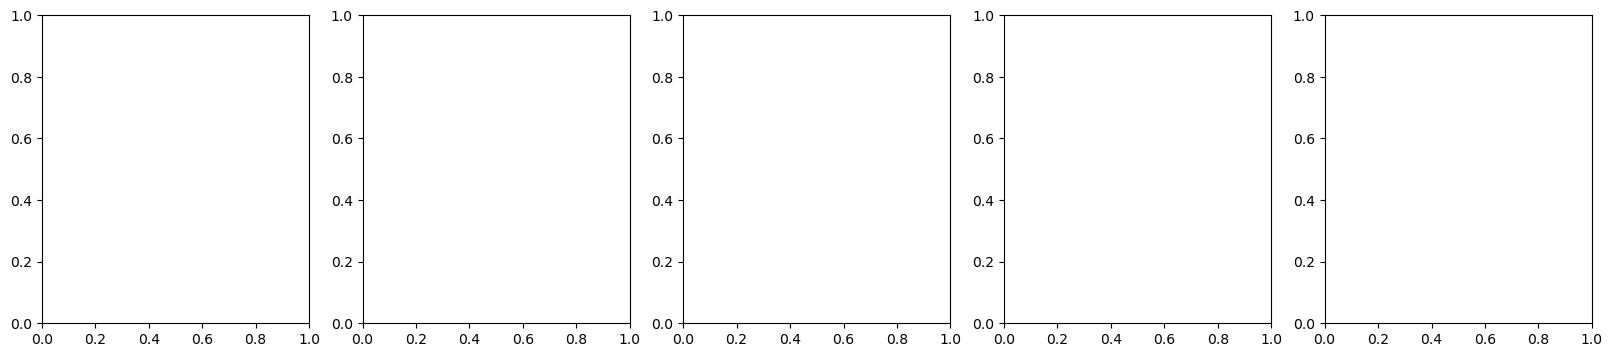

In [57]:
tile_number = (246, 289)

parent_dir = '/home/nick/astro/TileSlicer/'
cutout_dir = os.path.join(parent_dir, 'h5_files/')
os.makedirs(cutout_dir, exist_ok=True)
h5_filename = 'cutout_stacks_ugriz_lsb_200x200'
cutout_path = os.path.join(cutout_dir, h5_filename + f'_{tile_number[0]}_{tile_number[1]}.h5')
cutout = read_h5(cutout_path)

plot_cutout(cutout, band_dict)

In [53]:
cutout['images'].shape

(1, 5, 200, 200)

In [258]:
cutout['images'][6][0].shape

(200, 200)

In [262]:
tiles_five_bands[6]

(240, 291)

In [112]:
type(cutout['tile'][0])

numpy.int64

## VOSpace tile cuts

In [625]:
Client().copy('vos:cfis/tile.cuts', '/home/nick/astro/ssl-spencer/tiles.csv')
tiles = pd.read_csv('../tiles.csv', delimiter=r'\s+', header=None, names=['tile_numbers','ra_min','ra_max','dec_min','dec_max'])

In [626]:
tiles

,tile_numbers,ra_min,ra_max,dec_min,dec_max
0,0.240,-0.288675,0.288675,29.75,30.25
1,0.241,-0.290148,0.290148,30.25,30.75
2,0.242,-0.291658,0.291658,30.75,31.25
3,0.243,-0.293207,0.293207,31.25,31.75
4,0.244,-0.294795,0.294795,31.75,32.25
...,...,...,...,...,...
24346,620.240,357.668492,358.245842,29.75,30.25
24347,620.241,359.493404,360.073700,30.25,30.75
24348,621.240,358.245842,358.823192,29.75,30.25
24349,622.240,358.823192,359.400543,29.75,30.25
